In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color
import os
import random
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score
sns.set(style="white", palette="muted", color_codes=True)

In [2]:
path = '/home/aremirata/thesis/DIARETB30/diaretdb0_v_1_1/resources/images/'
images_list = np.sort(os.listdir(path+'diaretdb0_fundus_images/'))
labels_files = np.sort(os.listdir(path+'diaretdb0_groundtruths/'))

In [3]:
image_arrays = []
image_name = []
for i in images_list:
    img = Image.open(path+'diaretdb0_fundus_images/'+i)
    img_rs = img.resize((256,256), Image.ANTIALIAS)
    a = np.asarray(img_rs)
    image_arrays.append(a)
    image_name.append(i)

In [4]:
image_arrays = np.asarray(image_arrays)

In [5]:
target_labels = []
for i in labels_files:
    text_file = open(path+'diaretdb0_groundtruths/'+i, "r")
    target_labels.append(np.asarray(text_file.read().lower().split()))

In [6]:
target_labels = np.asarray(target_labels)

In [7]:
np.unique(target_labels)

array(['hardexudates', 'hemorrhages', 'n/a', 'neovascularisation',
       'redsmalldots', 'softexudates'], 
      dtype='<U18')

In [8]:
print(target_labels.shape)

(130, 5)


In [9]:
print(image_arrays.shape)

(130, 256, 256, 3)


In [10]:
target_labels_encoded = []
for i in target_labels:
    l = np.asarray([0 if j == 'n/a' else 1 for j in i])
    target_labels_encoded.append(l)

In [11]:
target_labels_encoded = np.asarray(target_labels_encoded)

In [12]:
target_labels_encoded.shape

(130, 5)

In [13]:
target_labels_modified = np.array([i/float(j) if j!=0 else i for i,j in zip(target_labels_encoded,np.sum(target_labels_encoded,axis=1))])

In [14]:
modified_classes = np.asarray([[1,0] if i==0 else [0,1] for i in np.sum(target_labels_encoded,axis=1)])

In [15]:
classes_unique = []
for i in range(target_labels.shape[1]):
    classes_unique = classes_unique + list(np.unique(target_labels[:,i])[np.unique(target_labels[:,i]) != 'n/a'])

In [16]:
classes_unique

['redsmalldots',
 'hemorrhages',
 'hardexudates',
 'softexudates',
 'neovascularisation']

In [17]:
modified_class_labels = ['normal','infected']

In [18]:
normal_retina_ids = np.argwhere(modified_classes[:,0]==1).reshape([-1])
affected_retina_ids = np.argwhere(modified_classes[:,0]==0).reshape([-1])

In [19]:
len(normal_retina_ids)

22

In [20]:
len(affected_retina_ids)

108

In [21]:
label_dict = {'normal':normal_retina_ids, 'affected': affected_retina_ids}

In [22]:
label_dict

{'affected': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109]),
 'normal': array([ 81,  94, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129])}

In [23]:
label_df = pd.DataFrame([label_dict]).transpose().reset_index().rename(columns={0:'indices','index':'label'})

In [24]:
label_df

,label,indices
0,affected,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,normal,"[81, 94, 110, 111, 112, 113, 114, 115, 116, 11..."


In [25]:
label_data = label_df.apply(lambda x: pd.Series(x['indices']), axis=1).stack().reset_index(level=1, drop=True)

In [26]:
label_data.name = 'index'

In [27]:
label_dataframe = label_df.drop('indices', axis=1).join(label_data)

In [28]:
label_dataframe.head()

,label,index
0,affected,0.0
0,affected,1.0
0,affected,2.0
0,affected,3.0
0,affected,4.0


In [29]:
targetmap = {'normal':0, 'affected':1}

In [30]:
label_dataframe['image_name'] = label_dataframe['index'].apply(lambda x: 'image'+str(int(x) + 1).zfill(3)+'.png')
label_dataframe['target'] = label_dataframe['label'].apply(lambda x: targetmap[x])
del label_dataframe['index']

In [31]:
label_dataframe.head()

,label,image_name,target
0,affected,image001.png,1
0,affected,image002.png,1
0,affected,image003.png,1
0,affected,image004.png,1
0,affected,image005.png,1


# Examine Normal Retina

In [32]:
normal_retina_ids

array([ 81,  94, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


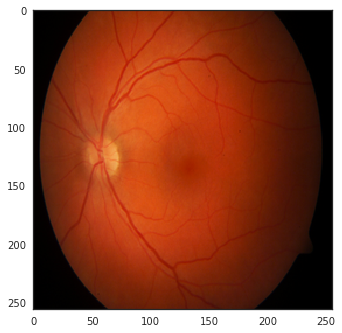

In [33]:
plt.imshow(image_arrays[81])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


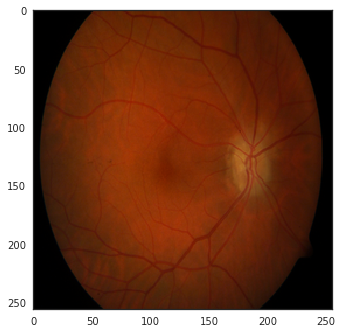

In [34]:
plt.imshow(image_arrays[94])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


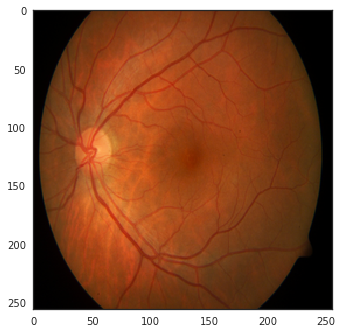

In [35]:
plt.imshow(image_arrays[129])

## Examine Affected Eyes

In [36]:
affected_retina_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


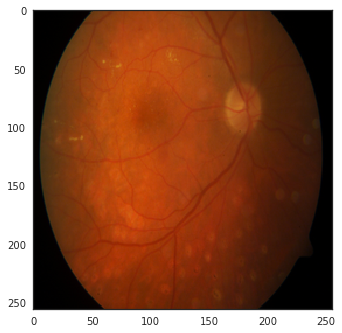

In [37]:
plt.imshow(image_arrays[0])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


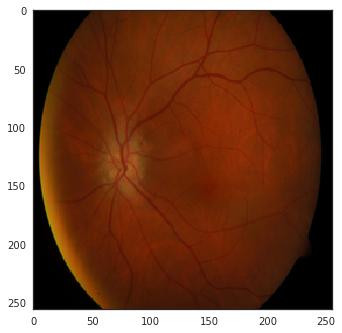

In [38]:
plt.imshow(image_arrays[95])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


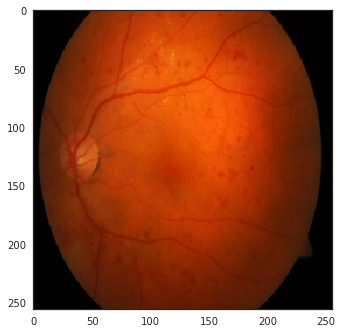

In [39]:
plt.imshow(image_arrays[109])

# Convert Images to GrayScale For Factorization

In [40]:
image_arrays_grayscale = []
for image in image_arrays:
    image_arrays_grayscale.append(color.rgb2gray(image))

# Examine Normal Eye Images In GrayScale

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


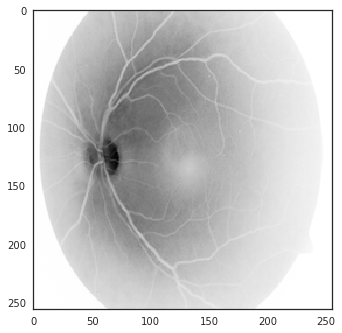

In [41]:
plt.imshow(image_arrays_grayscale[81])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


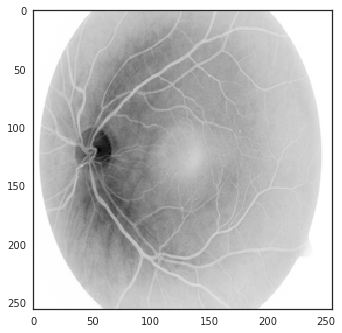

In [42]:
plt.imshow(image_arrays_grayscale[129])

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


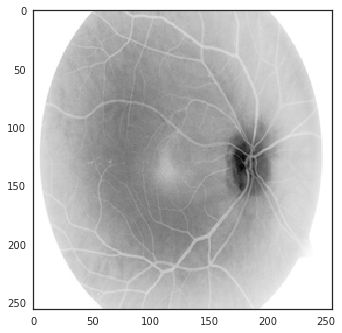

In [43]:
plt.imshow(image_arrays_grayscale[94])

In [44]:
image_arrays_grayscale[0].shape

(256, 256)

# Create a DataFrame to Store the Image Data Information

In [45]:
index = range(0, len(image_arrays_grayscale))
df_image = pd.DataFrame(index=index, columns=['image_name','grayscale_image'])
for i in range(len(image_arrays_grayscale)):
    df_image['image_name'][i] = image_name[i]
    df_image['grayscale_image'][i] = image_arrays_grayscale[i]

In [46]:
df_image.tail()

,image_name,grayscale_image
125,image126.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00..."
126,image127.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
127,image128.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
128,image129.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
129,image130.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002827..."


In [47]:
df_image['image_flatten'] = df_image['grayscale_image'].apply(lambda x: x.ravel())

In [48]:
df_image.head()

,image_name,grayscale_image,image_flatten
0,image001.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,image002.png,"[[0.000833333333333, 0.0, 0.000833333333333, 0...","[0.000833333333333, 0.0, 0.000833333333333, 0...."
2,image003.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,image004.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,image005.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [49]:
dataset_df = pd.merge(df_image,label_dataframe,on='image_name',how='inner')

In [50]:
dataset_df.head()

,image_name,grayscale_image,image_flatten,label,target
0,image001.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1
1,image002.png,"[[0.000833333333333, 0.0, 0.000833333333333, 0...","[0.000833333333333, 0.0, 0.000833333333333, 0....",affected,1
2,image003.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1
3,image004.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1
4,image005.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",affected,1


In [51]:
len(dataset_df),len(df_image),len(label_dataframe)

(130, 130, 130)

# Apply NMF to the DataSet

In [52]:
data = np.stack(dataset_df['image_flatten'].as_matrix(),axis=0)

In [53]:
data.shape

(130, 65536)

In [54]:
sparsity_value =  np.count_nonzero(data)/np.prod(data.shape)

In [55]:
sparsity_value

0.89875769981971154

# Uncompressed BPP Implementation

In [56]:
from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from numpy.linalg import norm, solve
from ntf_cython.nmf import nmf
from ntf_cython.random import rel_error

In [57]:
%time W, H, n_iter, rel_error = nmf(data, n_components=100, max_iter=200, random_state=42)

CPU times: user 3h 21min 50s, sys: 4min 11s, total: 3h 26min 1s
Wall time: 31min 35s


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


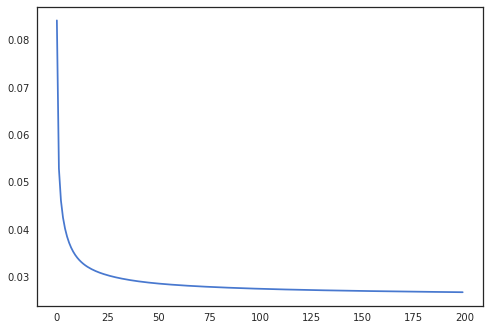

In [58]:
plt.plot(rel_error)

# Compressed NMF Implementation

## QR

In [59]:
%%time
U, V, relative_error = structured_randomized_bppnmf(data, q=10, r=100, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=42)

The matrix is dense. We use compressed block principal pivoting method


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 105 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 120 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 135 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 150 reached. Increase it to improve convergence.
  ConvergenceWarning)
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ntf_cython/nmf.py:196: ConvergenceWarning: Maximum number of iteration 165 reached. Increase it to improve convergenc

CPU times: user 16h 49min 51s, sys: 1h 48min 12s, total: 18h 38min 3s
Wall time: 4h 4min 54s


/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


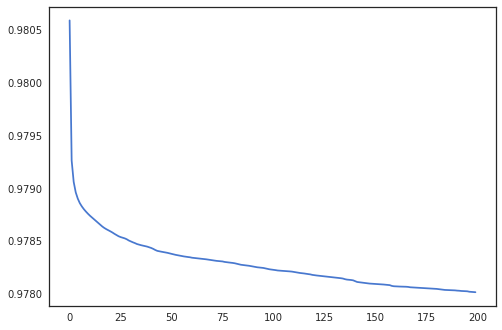

In [60]:
plt.plot(relative_error)

# Algo 41

In [ ]:
%%time
U, V, relative_error = structured_randomized_bppnmf(data, algo='algo41', q=10, r=100, max_iter = 200, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=42)

The matrix is dense. We use compressed block principal pivoting method
